<a href="https://colab.research.google.com/github/aldisstar/Taller-MIT/blob/main/Aldis_W2_CodeAssignment_Student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Requirements Installation

First, let's install everything that we need to run this notebook.

In [ ]:
!pip install Pillow==4.1.1
!pip install -U image
!pip install opencv-python
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
!pip install torch
!pip install torchvision
!pip install livelossplot

from tqdm import tqdm
from io import BytesIO

import cv2
import numpy as np
import PIL.Image
from IPython.display import Image, clear_output, display

# PyTorch will be out main tool for playing with neural networks
import torch
import torch.hub
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms

# We will use this library for plotting loss and accuracy during model training
from livelossplot import PlotLosses

# For reproducibility
torch.manual_seed(1234)

# CPU / GPU
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')

# Download function for model
import requests
def download(url, fn=None):
    if fn is None:
        fn = url.split('/')[-1]
    r = requests.get(url)
    if r.status_code == 200:
        open(fn, 'wb').write(r.content)
        print("{} downloaded: {:.2f} KB".format(fn, len(r.content) / 1024.0))
    else:
        print("url not found:", url)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 21.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 7.4 MB/s eta 0:00:00
  Created wheel for Pillow: filename=Pillow-4.1.1-cp310-cp310-linux_x86_64.whl size=926520 sha256=9e1d21b84469c46dd4906d40732a88c8769ae97b153e6fdaa2c83571191ae0b2
  Stored in directory: /root/.cache/pip/wheels/b3/2c/91/bd406baa8ce928c103abc325f483eadc72be6df4077ce42746
Successfully built Pillow
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bokeh 3.3.3 requires pillow>=7.1.0, but you have pillow 4.1.1 which is incompatible.
dopamine-rl 4.0.6 requires Pillow>=7.0.0, but you have pillow 4.1.1 which is incompatibl

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 7.7 MB/s eta 0:00:00
  Created wheel for image: filename=image-1.5.33-py2.py3-none-any.whl size=19482 sha256=ab9580b90673d35ce036967e71eda8af55c5976040d2431537a13191bc4c6ffb
  Stored in directory: /root/.cache/pip/wheels/70/0c/a4/7cfa53a5c6225c2db2bfec08e782b43d0f25fdae2e995b69be
Successfully built image
     - 91.8 kB 1.8 MB/s 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47874 sha256=28e5442fe16c22efe16392d55bd6858469d05eb461b802f9deaeee65642ff881
  Stored in directory: /tmp/pip-ephem-wheel-cache-6ob2rwsq/wheels/65/77/d5/d5ddeac9924f01d101ed3d2bf420c627eba535f8b8d93f27ee
Successfully built tqdm
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1
ERROR: pip's dependency resolver does not currently take into account all t

## Training Your Own Classifier!

In this problem set we are going to put together everything that we learned this week about image processing and neural networks. The goal is to train a small convolutional neural network to classify images of clothing items from the FashionMNIST dataset. You'll first fill in critical components of a simple PyTorch training pipeline, evaluate the model on the test set, and explore the impact of specific design choices and hyperparameters on the model's performance.

### Building an FashionMNIST Classifier

Using what we have learned, let's build a simple FasionMNIST classifier. Each element of the dataset is a 2-tuple: the 28x28 image and its label.


The [`torchvision`](https://pytorch.org/docs/stable/torchvision/index.html) library provides a wide range of standard vision datasets and networks with pretrained weights. We will use [the `torchvision.datasets.FashionMNIST` class](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST) to easily access the FasionMNIST dataset.

In deep learning, it is often a good idea to normalize network inputs to be centered around zero. We use the [`torchvision.transforms.Normalize`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize) tranform to achieve this. We compose the transforms together using the [`torchvision.transforms.Compose`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Compose) transform, which allows us to apply multiple transforms sequentially. We provide the following functions to help create the FashionMNIST dataset with these transforms:

In [ ]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
def get_transform(split='train'):
    return transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    )

def get_dataset(split='train', transform=None):
    return datasets.FashionMNIST(
        'data',
        train=split == 'train',
        download=True,
        transform=transform if transform is not None else transforms.ToTensor(),
    )

def get_dataloaders(batch_size=64, num_workers=2):
    '''Use Pytorch torch.utils.data.DataLoader to load batched data'''
    train_dataset = get_dataset('train', get_transform())
    val_dataset = get_dataset('val', get_transform())
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,  # shuffle training set
        num_workers=num_workers,  # turns on multi-processing loading so training is not blocked by data loading
        pin_memory=True,  # pin_memory allows faster transfer from CPU to GPU
    )
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    return train_dataloader, val_dataloader

print('training set size:\t{}'.format(len(get_dataset('train'))))
print('validation set size:\t{}'.format(len(get_dataset('val'))))

# Each element yielded by `train_loader` (a Python iterable) is still a 2-tuple,
# but now consisting of a batched image tensor, and a batched label tensor.
train_loader, _ = get_dataloaders()
images, labels = next(iter(train_loader))

print('batched image tensor shape: {}'.format(images.shape))
print('batched label tensor shape: {}'.format(labels.shape))

100%|████████████████████████████████████████████| 26421880/26421880 [00:01<00:00, 15879352.40it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 269236.37it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|███████████████████████████████████████████████| 4422102/4422102 [00:00<00:00, 5001365.80it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|█████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 5257432.92it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

training set size:	60000
validation set size:	10000
batched image tensor shape: torch.Size([64, 1, 28, 28])
batched label tensor shape: torch.Size([64])


### Visualizing the Data

Before we dive in to modelling, let's explore the data set that we will be working with. Below we have printed out a few examples from the training dataset.

Showing 10 random images:


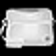

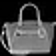

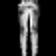

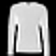

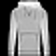

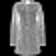

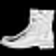

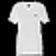

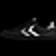

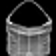

In [ ]:
def show_random_image():
  """This function shows a random image from the training data set"""

  dataset = np.array(train_loader.dataset.data)
  # Select a random index
  image_idx = np.random.randint(low=0, high=dataset.shape[0])
  # Convert the array to a Pillow image
  pil_image = PIL.Image.fromarray(np.array(train_loader.dataset.data[image_idx]))
  # Resize the Pillow image
  height, width = pil_image.size
  pil_image = pil_image.resize((height*2, width*2))
  # Display the image
  f = BytesIO()
  pil_image.save(f, 'png')
  display(Image(data=f.getvalue()))

# Show a sample of images from the dataset
num_images_to_show = 10
print(f'Showing {num_images_to_show} random images:')
for display_idx in range(num_images_to_show):
  show_random_image()
  print()


### Building the Network

We will use a convolutional network for classification. The following architecture is adapted from the famous [LeNet-5](https://ieeexplore.ieee.org/document/726791) [1].

lenet.svg

[1] LeCun, Yann, et al. "Gradient-based learning applied to document recognition." Proceedings of the IEEE 86.11 (1998): 2278-2324.



The following section creates the neural net class, using the __init__ and __forward__ functions.

In [ ]:
class MyNet(nn.Module):
    def __init__(
        self,
        num_classes=10,
        kernel_size=5,
        filter1_size=6,
        filter2_size=16,
        fc1_size=120,
        fc2_size=84,
    ):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=filter1_size,
            kernel_size=kernel_size,
            padding=2,
        )
        self.conv2 = nn.Conv2d(
            in_channels=filter1_size,
            out_channels=filter2_size,
            kernel_size=kernel_size,
        )
        self.fc1 = nn.Linear(in_features=filter2_size * kernel_size ** 2, out_features=fc1_size)
        self.fc2 = nn.Linear(in_features=fc1_size, out_features=fc2_size)
        self.fc3 = nn.Linear(in_features=fc2_size, out_features=num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

net = MyNet().to(device)

# This network output a size 10 vector for each input image, as verified below
# using a random input tensor.
net(torch.randn(32, 1, 28, 28, device=device)).shape

print(net)

MyNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Training Loop

For classification, we will use the cross-entropy loss [`F.cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) to train this network.

The training loop function is provided for you. It accepts a PyTorch dataloader, model and optimizer (as well as a device and current epoch), and trains the net for 1 epoch (one full pass through the training set).

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train(dataloader, model, optimizer, epoch):
    model.train()

    acc_meter = AverageMeter()

    # initiate for epoch accuracy/loss
    total_loss = 0
    total_correct = 0
    total_items = 0

    # Split our data into batches
    batches = tqdm(enumerate(dataloader), total=len(dataloader))
    batches.set_description("Epoch NA: Loss (NA) Accuracy (NA %)")
    for batch_idx, (data, target) in batches:

        # Move data to appropriate device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        data, target = data.to(device), target.to(device)

        # Zero out gradients
        optimizer.zero_grad()

        # Compute forward pass, loss, and gradients
        outputs = model(data)
        loss = F.cross_entropy(outputs, target)
        loss.backward()

        # Update parameters
        optimizer.step()

        # Update loss and accuracy
        total_loss += loss
        total_correct += torch.sum(torch.argmax(outputs, dim=1)==target)
        total_items += len(target)

        # Compute loss and accuracy as ratios
        loss_ratio = (total_loss/total_items).item()
        acc = (total_correct/total_items).item()
        acc_meter.update(acc)

        # Show the training accuracy
        batches.set_description(
            "Epoch {:d}: Loss ({:.2e}), Train Accuracy ({:02.0f}%)".format(
                epoch, loss.item(), 100.0 * acc_meter.avg
            )
        )

    return loss_ratio, acc_meter.avg


### Evaluating the Model

We also provide a function that evaluates our network on the validation set. This function accepts a PyTorch dataloader and model, and returns the loss ratio and accuracy.



In [ ]:
def evaluate(dataloader, net):
    total = 0
    correct = 0

    net.eval()  # puts the network in eval mode. this is important when the
    # network has layers that behaves differently in training and
    # evaluation time, e.g., dropout and batch norm.

    # initiate for epoch accuracy/loss
    test_loss = 0
    test_correct = 0
    test_items = 0

    for image, label in dataloader:
        image, label = image.to(device), label.to(device)

        with torch.no_grad():  # gradients are not tracked in this context manager
            # since we are evaluating, gradients are not needed
            # and we can save some time and GPU memory.

            # Get predictions
            prediction = net(image)

            # Calculate batch loss
            loss = F.cross_entropy(prediction, label)

            # Update loss and accuracy
            test_loss += loss
            test_correct += torch.sum(torch.argmax(prediction, dim=1) == label)
            test_items += len(label)

            # Compute loss and accuracy as ratios
            loss_ratio = (test_loss/test_items).item()
            acc = (test_correct/test_items).item()

    return loss_ratio, acc


In [ ]:
# Without any training, the network accuracy matches that of random guessing: ~10%.
_, val_loader = get_dataloaders(batch_size=32, num_workers=0)
print('At initialization, the network has accuracy {:.4f}%'.format(evaluate(val_loader, net)[1] * 100))

At initialization, the network has accuracy 10.1700%


### **Exercise 1**: Putting It All Together

Now that we have our functions for training and evaluating our models we can put everything together. Before you train your network, you will need to create an optimizer object. This will hold the current state of the network, and update the parameters based on the computed gradients. You can use the [optim](https://pytorch.org/docs/stable/optim.html) function (use the SGD algorithm).

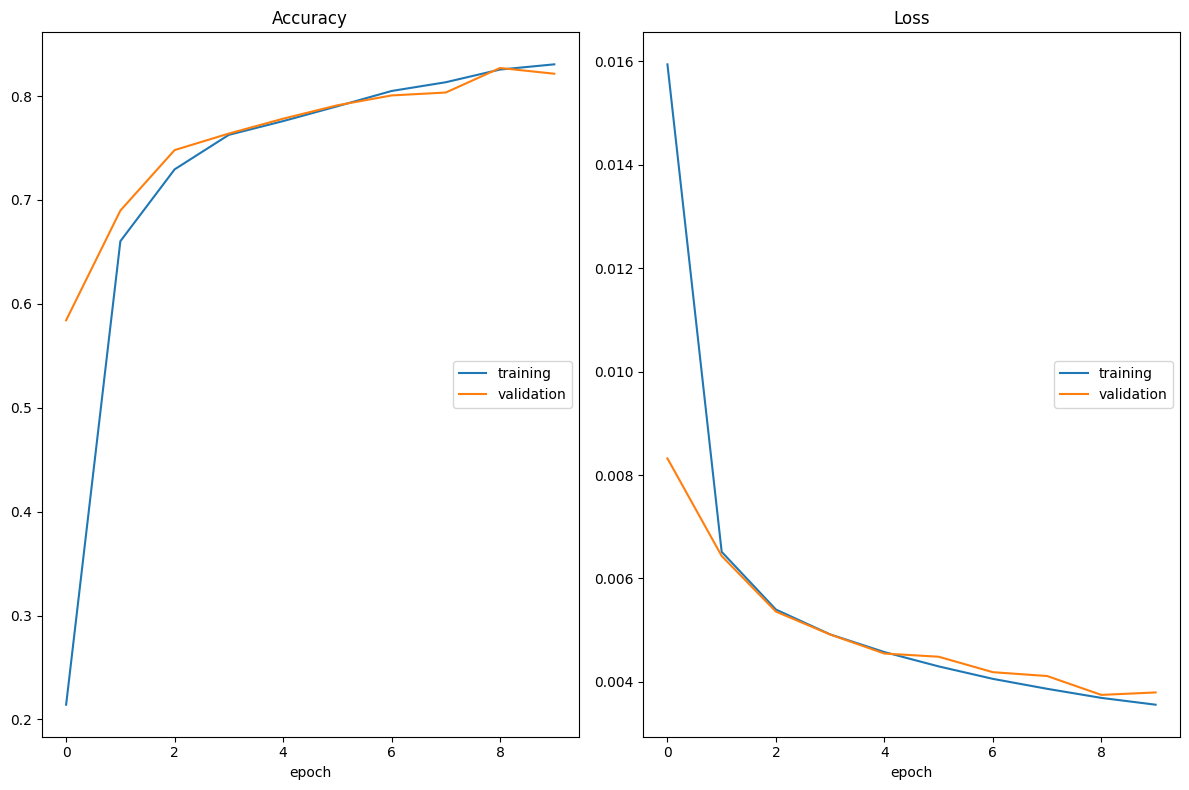

Accuracy
	training         	 (min:    0.214, max:    0.831, cur:    0.831)
	validation       	 (min:    0.584, max:    0.827, cur:    0.822)
Loss
	training         	 (min:    0.004, max:    0.016, cur:    0.004)
	validation       	 (min:    0.004, max:    0.008, cur:    0.004)
Done! 	Validation Accuracy: 82.1500%


In [ ]:
# We will use this function to plot our loss and accuracy curves as we train our model
plotlosses = PlotLosses()


# Define hyperparameters
num_epochs = 10
lr = 0.01

# Create optimizer - use the stochastic gradient descent algorithm for now
optim = torch.optim.SGD(net.parameters(), lr=lr)

# Get the train and validation sets using our dataloaders
train_loader, val_loader = get_dataloaders(batch_size=128)

# Let's train our network
for epoch in range(num_epochs):
    print('Epoch: {}\tValidation Accuracy: {:.4f}%'.format(epoch, evaluate(val_loader, net)[1] * 100))

    # Complete the following lines of code to train and evaluate the model

    train_loss, train_acc = train(train_loader, net, optim, num_epochs)
    val_loss, val_acc = evaluate(val_loader, net)

    # Plot the training and validation loss and accuracy for each epoch
    plotlosses.update({'acc': train_acc, 'val_acc': val_acc, 'loss': train_loss, 'val_loss': val_loss})
    plotlosses.draw()  # draw, update logs, etc

# Now we calculate it's accuracy using the validation set
_, valid_accuracy = evaluate(val_loader, net)
print('Done! \tValidation Accuracy: {:.4f}%'.format(valid_accuracy * 100))

## **Exercise 2**: Optimizing Your Network

We want you to get a feel for the impact of specific design choices on the performance of the network. The following hyperparameters / techniques may be useful for you to experiment with:

-   [Data augmentation](https://pytorch.org/vision/stable/transforms.html)
-   Network architecture (number of layers, filter size)
-   Number of epochs and/or batch size
-   Type of optimizer: [optim](https://pytorch.org/docs/stable/optim.html)
-   Learning rate and/or schedule: [lr_scheduler](https://pytorch.org/docs/stable/optim.html)

For the purposes of this assignment, we will only be looking at number of epochs. Feel free to play around with the other hyperparameters and techniques as well!

For the number of epochs, we will compare the accuracy of your modified network against the accuracy of the original network for both the training and validation sets. Write down the highest test accuracy that you can achieve. See if you can create a model with over 90% test accuracy.

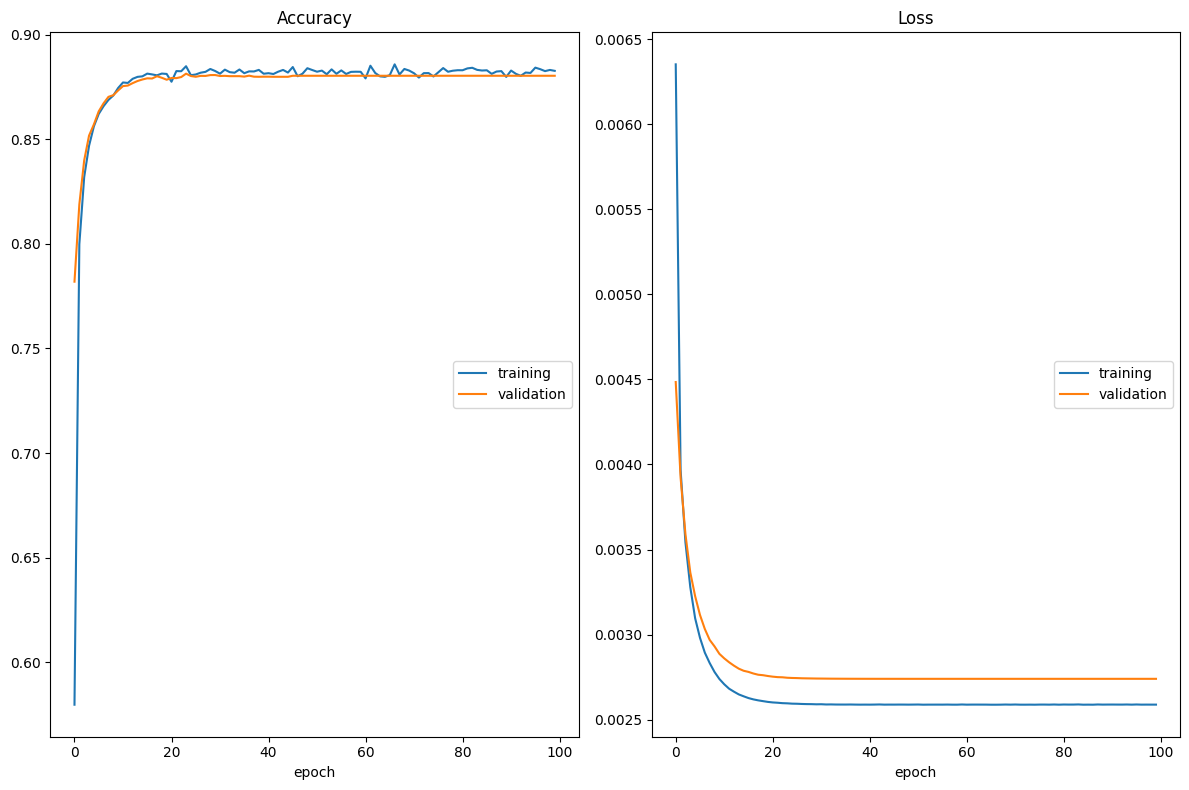

Accuracy
	training         	 (min:    0.580, max:    0.886, cur:    0.883)
	validation       	 (min:    0.782, max:    0.881, cur:    0.880)
Loss
	training         	 (min:    0.003, max:    0.006, cur:    0.003)
	validation       	 (min:    0.003, max:    0.004, cur:    0.003)
Done! 	Validation Accuracy: 87.6700%


In [ ]:
### NUMBER OF EPOCHS =100

plotlosses = PlotLosses()

# Create an instance of the Neural Network
net2 = MyNet().to(device)

# Define hyperparameters
num_epochs = 100

# Create optimizer
optim = torch.optim.Adamax(net2.parameters(), lr=.001)

# Create scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.8)

# Get the train and validation sets using our dataloaders
train_loader, val_loader = get_dataloaders(batch_size=128)

# Let's train our network
for epoch in range(num_epochs):
    print('Epoch: {}\tValidation Accuracy: {:.4f}%'.format(epoch, evaluate(val_loader, net2)[1] * 100))

    # Train and evaluate the model
    train_loss, train_acc = train(train_loader, net2, optim, num_epochs)
    val_loss, val_acc = train(val_loader, net2, optim, num_epochs)
    scheduler.step()

    # Plot the training and validation loss and accuracy for each epoch
    plotlosses.update({'acc': train_acc, 'val_acc': val_acc, 'loss': train_loss, 'val_loss': val_loss})
    plotlosses.draw()  # draw, update logs, etc

# Now we calculate the model's accuracy using the validation set
_, valid_accuracy = evaluate(val_loader, net2)
print('Done! \tValidation Accuracy: {:.4f}%'.format(valid_accuracy * 100))

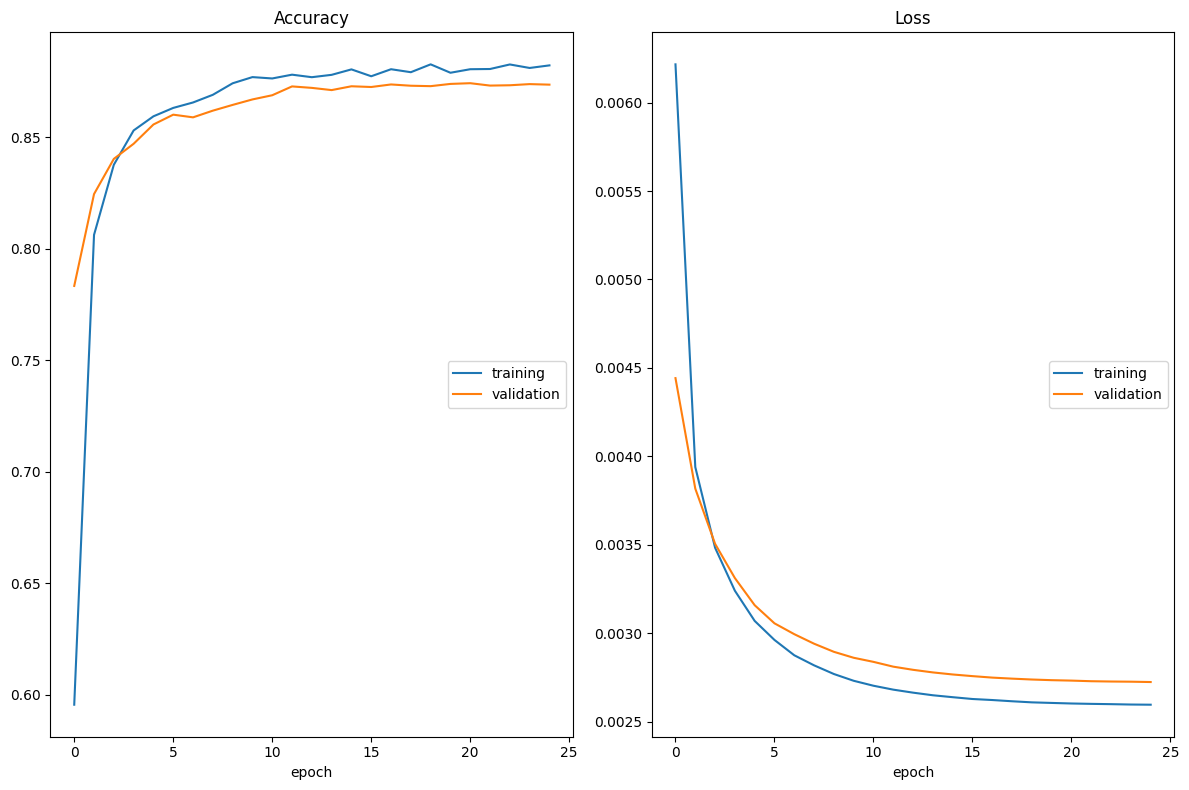

Accuracy
	training         	 (min:    0.595, max:    0.883, cur:    0.882)
	validation       	 (min:    0.783, max:    0.874, cur:    0.874)
Loss
	training         	 (min:    0.003, max:    0.006, cur:    0.003)
	validation       	 (min:    0.003, max:    0.004, cur:    0.003)
Done! 	Validation Accuracy: 87.3300%


In [ ]:
### NUMBER OF EPOCHS =25

plotlosses = PlotLosses()

# Create an instance of the Neural Network
net2 = MyNet().to(device)

# Define hyperparameters
num_epochs = 25

# Create optimizer
optim = torch.optim.Adamax(net2.parameters(), lr=.001)

# Create scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.8)

# Get the train and validation sets using our dataloaders
train_loader, val_loader = get_dataloaders(batch_size=128)

# Let's train our network
for epoch in range(num_epochs):
    print('Epoch: {}\tValidation Accuracy: {:.4f}%'.format(epoch, evaluate(val_loader, net2)[1] * 100))

    # Train and evaluate the model
    train_loss, train_acc = train(train_loader, net2, optim, num_epochs)
    val_loss, val_acc = train(val_loader, net2, optim, num_epochs)
    scheduler.step()

    # Plot the training and validation loss and accuracy for each epoch
    plotlosses.update({'acc': train_acc, 'val_acc': val_acc, 'loss': train_loss, 'val_loss': val_loss})
    plotlosses.draw()  # draw, update logs, etc

# Now we calculate the model's accuracy using the validation set
_, valid_accuracy = evaluate(val_loader, net2)
print('Done! \tValidation Accuracy: {:.4f}%'.format(valid_accuracy * 100))